### Import Libraries

In [1]:
"If it does not work use code below while running this notebook in this dir."
# import sys
# import os
# sys.path.append(os.path.abspath(os.getcwd()))

from mytorch import Tensor, Model
from mytorch import activation as active_func
from mytorch import loss as loss_func
from mytorch import optimizer as optim 
from mytorch import layer as nn
from mytorch.util import DataLoader

from mytorch.util import flatten

import matplotlib.pyplot as plt

from tqdm.auto import tqdm

/home/mmdsparrow/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load MNIST

In [2]:
"""
load data set with given data loader.
you have 10000 train data, 1000 for each number, remember to shuffle training data.
you have 1000 test data, 100 for each number.

loaded data is a list of (img, label)
type of img is Tensor.

TODO: you have to get this list and create batches for training.
you can also apply this changes later in the Training part for convenience.
"""
data_loader = DataLoader(train_addr='MNIST_light/MNIST/train', test_addr='MNIST_light/MNIST/test')
data_loader.load(train_batch_size=128, test_batch_size=32, do_normalize=True)
"you can see how data is loaded"
# print(data_loader.getTrain()[0][0].shape)
# print(data_loader.getTrain()[0][1].shape)

loading train...
loading test...
processing...


'you can see how data is loaded'

### Define and Create your Model

In [3]:
class MyModel(Model):
    def __init__(self):
        "TODO: define your layers. order is important" 
        self.conv2d1= nn.Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
        self.conv2d2= nn.Conv2d(10, 10, kernel_size=(5, 5), stride=(1, 1))
        self.mp = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        # self.fc1 = nn.Linear(4*10*100,100, need_bias=False)
        # self.fc1 = nn.Linear(4000,100, need_bias=False)
        self.fc1 = nn.Linear(160,100, need_bias=False)
        self.fc2 = nn.Linear(100,10, need_bias=False)
        self.relu = active_func.relu
        self.softmax = active_func.softmax

    def forward(self, x: Tensor) -> Tensor:
        "TODO: define forward pass"
        x = self.conv2d1(x)
        x = self.relu(x) #24x24x10
        x = self.mp(x) #12x12x10
        x = self.conv2d2(x)
        # x = self.relu(x) #8x8x10
        x = self.mp(x) #4x4x10
        # x = x.view(-1, 4*4*10) #flattening
        x = flatten(x)
        # print(f'after flatten: {x.shape}')
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

model = MyModel()
model.summary()

conv2d1:  conv 2d - total params: 25 - kernel: (5, 5), stride: (1, 1), padding: (0, 0)
conv2d2:  conv 2d - total params: 25 - kernel: (5, 5), stride: (1, 1), padding: (0, 0)
mp:  max pool 2d - kernel: (2, 2), stride: (2, 2), padding: (0, 0)
fc1:  linear - total param: 16000 - in: 160, out: 100
fc2:  linear - total param: 1000 - in: 100, out: 10


### Choose a Loss Function

In [4]:
"TODO: choose a proper loss function"
criterion = loss_func.CategoricalCrossEntropy

### Choose an Optimizer

In [5]:
"TODO: choose a proper optimizer"
optimizer = optim.SGD(model.parameters(), learning_rate=0.01)

### training methods

In [6]:
# just use it for argmax
import numpy as np

def train_one_epoch(model: Model, data_loader, optimizer: optim, criterion, length):
  acc = 0

  optimizer.zero_grad()

  for batch in data_loader.getTrain():
      x_train_dev = batch[0]
      y_train_dev = batch[1]

      y_pred_dev = model(x_train_dev)

      loss = criterion(y_pred_dev, y_train_dev)

      loss.backward()

      optimizer.step()

      yp= np.argmax(y_pred_dev.data, axis=1)
      acc += np.sum(yp == y_train_dev.data)

  return acc/length



def caluculate_acc(data_loader, model, length):
  acc = 0
  for batch in data_loader.getTest():
    x_test_dev = batch[0]
    y_test_dev = batch[1]
    # show_batch(x_test_dev, y_test_dev)
    yp = model(x_test_dev)
    
    yp= np.argmax(yp.data, axis=1)
    acc += np.sum(yp == y_test_dev.data)
    print(f'batch accuracy: {acc}')
    
  return acc / length


def show_batch(X_train, y_train):
  plt.figure(figsize=(10,10))
  for i in range(64):
      plt.subplot(8,8,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(X_train[i].data, cmap=plt.cm.binary)
      plt.xlabel(y_train[i].data)
  plt.show()

### Training Model

In [7]:
"TODO: define number of epoch and train batches of data on your model. also test each epoch."
EPOCH = 10

train_acc = []
test_acc = []
best_train_acc = 0.0
best_test_acc = 0.0

for i in tqdm(range(EPOCH)):

    "TODO: train over your defined batches and save train accuracy for each epoch."
    # train_acc.append(train_one_epoch(model, data_loader, optimizer, criterion, 10000)[1].item())
    train_acc.append(train_one_epoch(model, data_loader, optimizer, criterion, 10000))
    
    if best_train_acc < train_acc[-1]:
        best_train_acc = train_acc[-1]

    "TODO: test your model after each training and save test accuracy for each epoch."

    # test_acc.append(caluculate_acc(data_loader, model, 1000).item())
    test_acc.append(caluculate_acc(data_loader, model, 1000))


    if best_test_acc < test_acc[-1]:
        best_test_acc = test_acc[-1]

    if train_acc[-1] > 0.99 and test_acc[-1] > 0.99:
        break

  0%|          | 0/10 [00:00<?, ?it/s]

after flatten: (128, 160)
after flatten: (128, 160)
after flatten: (128, 160)
after flatten: (128, 160)
after flatten: (128, 160)
after flatten: (128, 160)
after flatten: (128, 160)


  0%|          | 0/10 [04:27<?, ?it/s]


KeyboardInterrupt: 

### Evaluate Model Performance

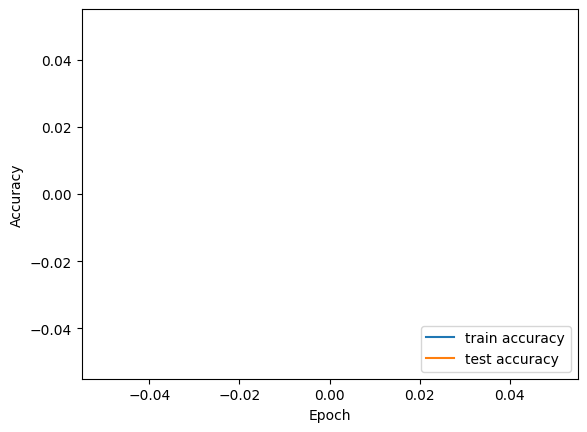

IndexError: list index out of range

In [16]:
plt.plot(train_acc, label='train accuracy')
plt.plot(test_acc, label = 'test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

print("\nOn train - best accuracy: {:.2f}, final accuracy: {:.2f}".format(best_train_acc, train_acc[-1]))
print("On test - best accuracy: {:.2f}, final accuracy: {:.2f}".format(best_test_acc, test_acc[-1]))